In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, draw, show, ion
import matplotlib.image as mpimg
import cv2
import scipy.io
from tqdm import tqdm

# from scipy.stats import ortho_group

from pmf import *
from utils import *
from numba import njit
import os
import warnings
warnings.filterwarnings("ignore")
np.random.seed(250)

In [2]:
def Subplot_RGB_images(I, imsize = [3240, 4320], height = 15, width = 15, title = ''):
    n_images = I.shape[0]
    Im = [I[i,:].reshape(imsize[0],imsize[1],3) for i in range(I.shape[0])]
    fig, ax = plt.subplots(1,n_images, figsize = (25,50))
    fig.suptitle(title)
    fig.set_figheight(height)
    fig.set_figwidth(width)   
    for i in range(n_images):
        ax[i].imshow(Im[i])
        ax[i].axes.xaxis.set_visible(False)
        ax[i].axes.yaxis.set_visible(False)
    plt.subplots_adjust(right=0.97,\
                    left=0.03,\
                    bottom=0.03,\
                    top=0.97,\
                    wspace=0.1,\
                    hspace=0.1)
    plt.draw()    

In [3]:
image_paths = 'TestImages'
images = []
for im_dir in os.listdir(image_paths):
    try:
        images.append(mpimg.imread(os.path.join(image_paths,im_dir)))
    except:
        pass
images = np.array(images)

In [4]:
small_images = np.zeros((images.shape[0],324* 432* 3))
small_to_large_image_size_ratio = 0.1
for i in range(images.shape[0]):
    small_img = cv2.resize(images[i], # original image
                           (0,0), # set fx and fy, not the final size
                           fx=small_to_large_image_size_ratio, 
                           fy=small_to_large_image_size_ratio, 
                           interpolation=cv2.INTER_NEAREST)
    if small_img.shape[0] == 302:
        small_img = cv2.resize(small_img, (0,0), fx = 432/403, fy = 324/302)
    print(small_img.shape)
    small_images[i] = small_img.reshape(-1,)/255

small_images.shape

(324, 432, 3)
(324, 432, 3)
(324, 432, 3)
(324, 432, 3)
(324, 432, 3)
(324, 432, 3)
(324, 432, 3)
(324, 432, 3)
(324, 432, 3)
(324, 432, 3)
(324, 432, 3)
(324, 432, 3)
(324, 432, 3)
(324, 432, 3)
(324, 432, 3)


(15, 419904)

<IPython.core.display.Math object>

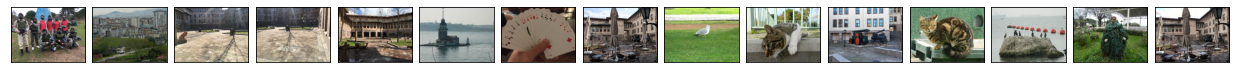

In [5]:
S = small_images.copy()
Subplot_RGB_images(S, imsize = [324,432], height = 4, width = 18)
display_matrix(np.corrcoef(S))
# plt.savefig('Original_Images3.pdf', format = 'pdf', dpi = 1500)

<IPython.core.display.Math object>

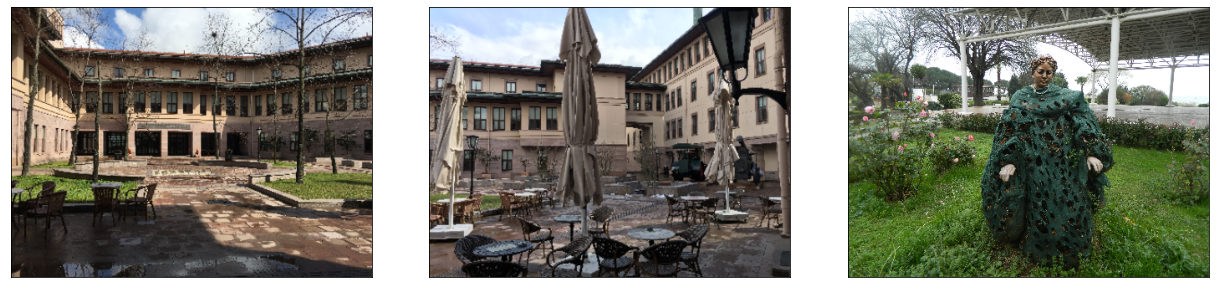

In [6]:
S = small_images[[4,7,13]]
Subplot_RGB_images(S, imsize = [324,432], height = 4, width = 18)
display_matrix(np.corrcoef(S))
plt.savefig('Original_Images3.pdf', format = 'pdf', dpi = 1500)

In [7]:
np.random.seed(50)
NumberofMixtures = 5
NumberofSources = 3
# S_ = 2 * S - 1
INPUT_STD = 0.28
A = np.random.standard_normal(size=(NumberofMixtures,NumberofSources))
# A = np.random.uniform(size=(NumberofMixtures,NumberofSources))
X = A @ S
for M in range(A.shape[0]):
    stdx = np.std(X[M,:])
    A[M,:] = A[M,:]/stdx * INPUT_STD
    
SNR=40
# A = np.abs(A)
Xn = A @ S
Noisecomp=np.random.randn(A.shape[0],S.shape[1])*np.power(10,-SNR/20)*INPUT_STD
X=Xn+Noisecomp

print(20*np.log10(np.std(Xn)/np.std(Noisecomp)))

X_ = ZeroOneNormalizeColumns(X.T).T
print('The following is the mixture matrix')
display_matrix(A)

41.122659361820595
The following is the mixture matrix


<IPython.core.display.Math object>

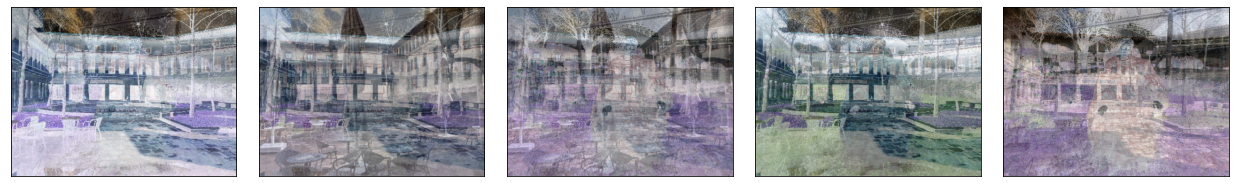

In [8]:
Subplot_RGB_images(X_, imsize = [324,432], height = 3, width = 18)
# plt.savefig('Mixture_Images3.pdf', format = 'pdf', dpi = 1500)

In [9]:
from time import time

In [10]:
batch_size = 40000
pmf1=pmf(X[:,:batch_size],3)
pmf1.SetGroundTruth(S[:,:batch_size].T)
t0 = time()
pmf1.nonnegative_antisparse(algorithm_iterations=252000,step_size_scale=200)
t1 = time()

In [11]:
(t1 - t0)/60

7.882233679294586

In [12]:
Ypmf = pmf1.H.T
Wf = Ypmf @ np.linalg.pinv(X[:,:batch_size])
Y_ = Wf @ X
Y_ = signed_and_permutation_corrected_sources(S.T,Y_.T)
coef_ = (Y_ * S.T).sum(axis = 0) / (Y_ * Y_).sum(axis = 0)
Y_ = coef_ * Y_
snr(S.T,Y_)

array([31.77875267, 36.68364983, 27.72292897])

In [13]:
CalculateSIR(A, Wf), 10 * np.log10(CalculateSINR(Wf @ X, S)[0])

((26.658802570924923, 3), 31.923649428235578)

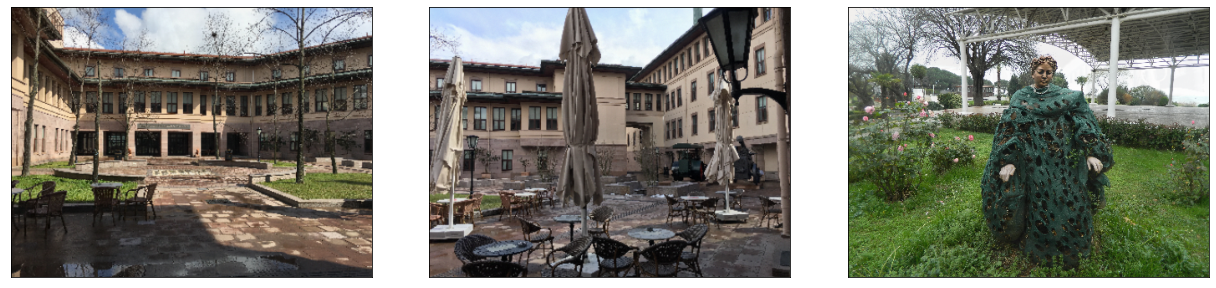

In [14]:
Subplot_RGB_images(ZeroOneNormalizeColumns(Y_).T, imsize = [324,432], height = 4, width = 18)
plt.savefig('PMF_Output.pdf', format = 'pdf', dpi = 1500)

In [15]:
S.shape

(3, 419904)